In [6]:
import geopandas as gpd
import pandas as pd

# Read the file
df = gpd.read_file(r"D:\KUL MSDS 1\GRBcade60d34.dxf")

# Extract ALL building types
building_layers = ['GBG1', 'GBG2', 'GBG3', 'INGESCHETSTGEBOUW', 'SGBG']
df_buildings = df[df['Layer'].isin(building_layers)]

print(f"Total buildings found: {len(df_buildings)}")

# Check CRS
print(f"CRS: {df_buildings.crs}")

# Calculate areas
df_buildings = df_buildings.copy()
df_buildings["area_m2"] = df_buildings.geometry.area

# Check area statistics
print(f"Min area: {df_buildings['area_m2'].min():.6f} m²")
print(f"Max area: {df_buildings['area_m2'].max():.6f} m²") 
print(f"Mean area: {df_buildings['area_m2'].mean():.6f} m²")

# Check how many buildings at different thresholds
thresholds = [1, 10, 50, 100, 200, 500]
for threshold in thresholds:
    count = len(df_buildings[df_buildings["area_m2"] >= threshold])
    print(f"Buildings >= {threshold}m²: {count}")

# Let's look at the actual largest buildings
largest_buildings = df_buildings.nlargest(5, 'area_m2')
print("\nLargest 5 buildings:")
for i, (idx, row) in enumerate(largest_buildings.iterrows()):
    print(f"  {i+1}. Area: {row['area_m2']:.6f} m², Layer: {row['Layer']}")

Total buildings found: 43043
CRS: None
Min area: 0.000000 m²
Max area: 0.000000 m²
Mean area: 0.000000 m²
Buildings >= 1m²: 0
Buildings >= 10m²: 0
Buildings >= 50m²: 0
Buildings >= 100m²: 0
Buildings >= 200m²: 0
Buildings >= 500m²: 0

Largest 5 buildings:
  1. Area: 0.000000 m², Layer: GBG1
  2. Area: 0.000000 m², Layer: GBG1
  3. Area: 0.000000 m², Layer: GBG1
  4. Area: 0.000000 m², Layer: GBG1
  5. Area: 0.000000 m², Layer: GBG1


In [17]:
import geopandas as gpd
import pandas as pd

# Read the file
df = gpd.read_file(r"D:\KUL MSDS 1\GRBcade60d34.dxf")

# Extract buildings
building_layers = ['GBG1', 'GBG2', 'GBG3', 'INGESCHETSTGEBOUW', 'SGBG']
df_buildings = df[df['Layer'].isin(building_layers)].copy()

# Calculate bounding box dimensions properly
bounds = df_buildings.geometry.bounds
df_buildings['bbox_width'] = bounds['maxx'] - bounds['minx']
df_buildings['bbox_height'] = bounds['maxy'] - bounds['miny']
df_buildings['estimated_area_m2'] = df_buildings['bbox_width'] * df_buildings['bbox_height']

print(f"Estimated area statistics:")
print(f"Min: {df_buildings['estimated_area_m2'].min():.2f}")
print(f"Max: {df_buildings['estimated_area_m2'].max():.2f}")
print(f"Mean: {df_buildings['estimated_area_m2'].mean():.2f}")

# Now use this estimated area for our calculations
LARGE_ROOF_MIN_M2 = 500
candidates = df_buildings[df_buildings['estimated_area_m2'] >= LARGE_ROOF_MIN_M2].copy()

print(f"Found {len(candidates)} candidates with estimated area >= 500m²")

# If we found candidates, proceed with CO2 calculations
if len(candidates) > 0:
    FILL_FACTOR = 0.6
    KWH_PER_M2 = 200.0
    CO2_KG_PER_KWH = 0.23
    TOTAL_GRID_CAPACITY_KW = 130000
    SOLAR_POWER_DENSITY_KW_PER_M2 = 0.2

    candidates["panel_m2"] = candidates["estimated_area_m2"] * FILL_FACTOR
    candidates["kwh_year"] = candidates["panel_m2"] * KWH_PER_M2
    candidates["co2_tons"] = candidates["kwh_year"] * CO2_KG_PER_KWH / 1000.0
    candidates["rank"] = candidates["co2_tons"].rank(ascending=False, method="dense").astype(int)

    candidates["solar_capacity_kw"] = candidates["panel_m2"] * SOLAR_POWER_DENSITY_KW_PER_M2
    candidates["congestion_ratio"] = candidates["solar_capacity_kw"] / TOTAL_GRID_CAPACITY_KW
    candidates["congestion_percentage"] = candidates["congestion_ratio"] * 100
    candidates["solar_priority_score"] = (candidates["solar_capacity_kw"] / candidates["solar_capacity_kw"].max() * 100).round(2)

    top200 = candidates.sort_values("co2_tons", ascending=False).head(200).copy()
    
    print(f"Top 200 candidates ready!")
else:
    print("No candidates found. Try lowering the threshold.")

Estimated area statistics:
Min: 0.45
Max: 234712.24
Mean: 284.29
Found 2735 candidates with estimated area >= 500m²
Top 200 candidates ready!


In [18]:
import geopandas as gpd
import pandas as pd

# Read the file
df = gpd.read_file(r"D:\KUL MSDS 1\GRBcade60d34.dxf")

# Extract buildings
building_layers = ['GBG1', 'GBG2', 'GBG3', 'INGESCHETSTGEBOUW', 'SGBG']
df_buildings = df[df['Layer'].isin(building_layers)].copy()

# Calculate bounding box dimensions properly
bounds = df_buildings.geometry.bounds
df_buildings['bbox_width'] = bounds['maxx'] - bounds['minx']
df_buildings['bbox_height'] = bounds['maxy'] - bounds['miny']
df_buildings['estimated_area_m2'] = df_buildings['bbox_width'] * df_buildings['bbox_height']

print(f"Estimated area statistics:")
print(f"Min: {df_buildings['estimated_area_m2'].min():.2f}")
print(f"Max: {df_buildings['estimated_area_m2'].max():.2f}")
print(f"Mean: {df_buildings['estimated_area_m2'].mean():.2f}")

# Now use this estimated area for our calculations
LARGE_ROOF_MIN_M2 = 500
candidates = df_buildings[df_buildings['estimated_area_m2'] >= LARGE_ROOF_MIN_M2].copy()

print(f"Found {len(candidates)} candidates with estimated area >= 500m²")

# If we found candidates, proceed with CO2 calculations
if len(candidates) > 0:
    FILL_FACTOR = 0.6
    KWH_PER_M2 = 200.0
    CO2_KG_PER_KWH = 0.23
    TOTAL_GRID_CAPACITY_KW = 130000
    SOLAR_POWER_DENSITY_KW_PER_M2 = 0.2

    candidates["panel_m2"] = candidates["estimated_area_m2"] * FILL_FACTOR
    candidates["kwh_year"] = candidates["panel_m2"] * KWH_PER_M2
    candidates["co2_tons"] = candidates["kwh_year"] * CO2_KG_PER_KWH / 1000.0
    candidates["rank"] = candidates["co2_tons"].rank(ascending=False, method="dense").astype(int)

    candidates["solar_capacity_kw"] = candidates["panel_m2"] * SOLAR_POWER_DENSITY_KW_PER_M2
    candidates["congestion_ratio"] = candidates["solar_capacity_kw"] / TOTAL_GRID_CAPACITY_KW
    candidates["congestion_percentage"] = candidates["congestion_ratio"] * 100
    candidates["solar_priority_score"] = (candidates["solar_capacity_kw"] / candidates["solar_capacity_kw"].max() * 100).round(2)

    top200 = candidates.sort_values("co2_tons", ascending=False).head(200).copy()
    
    print(f"Top 200 candidates ready!")
else:
    print("No candidates found. Try lowering the threshold.")

Estimated area statistics:
Min: 0.45
Max: 234712.24
Mean: 284.29
Found 2735 candidates with estimated area >= 500m²
Top 200 candidates ready!


In [20]:
import geopandas as gpd
import pandas as pd

# Read the file
df = gpd.read_file(r"D:\KUL MSDS 1\GRBcade60d34.dxf")

# Extract buildings
building_layers = ['GBG1', 'GBG2', 'GBG3', 'INGESCHETSTGEBOUW', 'SGBG']
df_buildings = df[df['Layer'].isin(building_layers)].copy()

# Calculate bounding box dimensions properly
bounds = df_buildings.geometry.bounds
df_buildings['bbox_width'] = bounds['maxx'] - bounds['minx']
df_buildings['bbox_height'] = bounds['maxy'] - bounds['miny']
df_buildings['estimated_area_m2'] = df_buildings['bbox_width'] * df_buildings['bbox_height']

# Now use this estimated area for our calculations
LARGE_ROOF_MIN_M2 = 500
candidates = df_buildings[df_buildings['estimated_area_m2'] >= LARGE_ROOF_MIN_M2].copy()

# CO2 calculation parameters
FILL_FACTOR = 0.6
KWH_PER_M2 = 200.0
CO2_KG_PER_KWH = 0.23
TOTAL_GRID_CAPACITY_KW = 130000
SOLAR_POWER_DENSITY_KW_PER_M2 = 0.2

candidates["panel_m2"] = candidates["estimated_area_m2"] * FILL_FACTOR
candidates["kwh_year"] = candidates["panel_m2"] * KWH_PER_M2
candidates["co2_tons"] = candidates["kwh_year"] * CO2_KG_PER_KWH / 1000.0
candidates["rank"] = candidates["co2_tons"].rank(ascending=False, method="dense").astype(int)

candidates["solar_capacity_kw"] = candidates["panel_m2"] * SOLAR_POWER_DENSITY_KW_PER_M2
candidates["congestion_ratio"] = candidates["solar_capacity_kw"] / TOTAL_GRID_CAPACITY_KW
candidates["congestion_percentage"] = candidates["congestion_ratio"] * 100
candidates["solar_priority_score"] = (candidates["solar_capacity_kw"] / candidates["solar_capacity_kw"].max() * 100).round(2)

top200 = candidates.sort_values("co2_tons", ascending=False).head(200).copy()

# Clean output - only show the important columns with nice formatting
result_columns = ['rank', 'estimated_area_m2', 'panel_m2', 'kwh_year', 'co2_tons', 'solar_capacity_kw']
clean_results = top200[result_columns].round(2)

# Rename columns to be more readable
clean_results = clean_results.rename(columns={
    'estimated_area_m2': 'roof_area_m2',
    'panel_m2': 'solar_panel_area_m2',
    'kwh_year': 'annual_energy_kwh',
    'co2_tons': 'co2_reduction_tons',
    'solar_capacity_kw': 'solar_capacity_kw'
})

print("Top 200 Buildings by CO2 Reduction Potential:")
print("=" * 80)
print(clean_results.to_string(index=False))

Top 200 Buildings by CO2 Reduction Potential:
 rank  roof_area_m2  solar_panel_area_m2  annual_energy_kwh  co2_reduction_tons  solar_capacity_kw
    1     234712.24            140827.34        28165468.62             6478.06           28165.47
    2     130902.31             78541.38        15708276.61             3612.90           15708.28
    3      85717.97             51430.78        10286156.90             2365.82           10286.16
    4      64054.34             38432.60         7686520.73             1767.90            7686.52
    5      51577.27             30946.36         6189272.61             1423.53            6189.27
    6      45067.55             27040.53         5408105.79             1243.86            5408.11
    7      39632.92             23779.75         4755949.87             1093.87            4755.95
    8      37777.42             22666.45         4533290.83             1042.66            4533.29
    9      36051.00             21630.60         4326120.11    

Top 3 Buildings by CO2 Reduction Potential:

Rank 1:
  Estimated Roof Area: 234712 m²
  Solar Panel Area: 140827 m²
  Annual Energy Production: 28165469 kWh
  CO2 Reduction: 6478.1 tons/year
  Solar Capacity: 28165.5 kW
  Priority Score: 100.0

Rank 2:
  Estimated Roof Area: 130902 m²
  Solar Panel Area: 78541 m²
  Annual Energy Production: 15708277 kWh
  CO2 Reduction: 3612.9 tons/year
  Solar Capacity: 15708.3 kW
  Priority Score: 55.8

Rank 3:
  Estimated Roof Area: 85718 m²
  Solar Panel Area: 51431 m²
  Annual Energy Production: 10286157 kWh
  CO2 Reduction: 2365.8 tons/year
  Solar Capacity: 10286.2 kW
  Priority Score: 36.5

Creating interactive map...
Interactive map saved as 'top3_solar_roofs.html'
Open this file in a web browser to view the map

Creating static plot...
Static plot saved as 'top3_solar_roofs_plot.png'


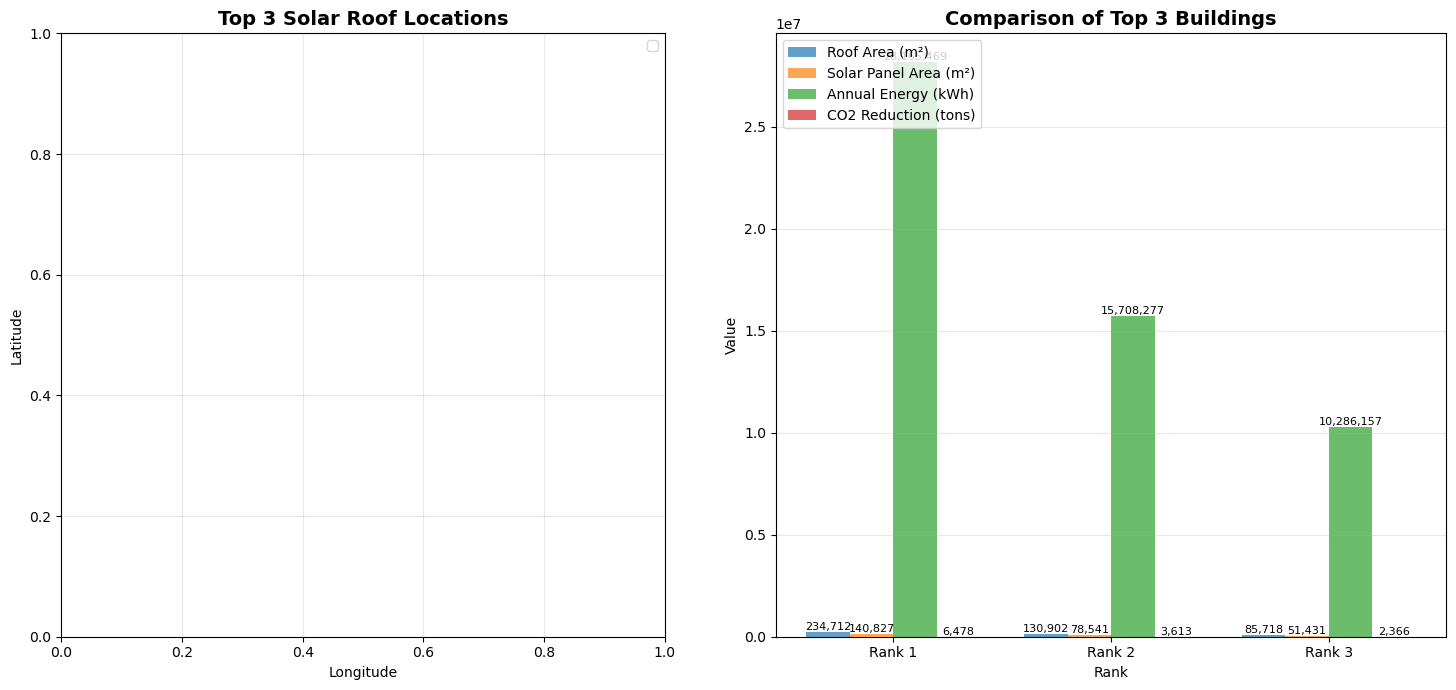


Detailed Coordinates for Top 3 Buildings:

Rank 1:
  Bounding Box:
    Min Longitude: 171176.834010
    Min Latitude: 174028.865211
    Max Longitude: 171657.928026
    Max Latitude: 174516.737083
  Centroid: Longitude 171401.498763, Latitude 174260.402383
  Approx. Dimensions: 481.1 m × 487.9 m

Rank 2:
  Bounding Box:
    Min Longitude: 173993.496540
    Min Latitude: 175064.359996
    Max Longitude: 174305.736412
    Max Latitude: 175483.596348
  Centroid: Longitude 174134.584062, Latitude 175281.163988
  Approx. Dimensions: 312.2 m × 419.2 m

Rank 3:
  Bounding Box:
    Min Longitude: 175103.161309
    Min Latitude: 170574.730809
    Max Longitude: 175401.518237
    Max Latitude: 170862.030905
  Centroid: Longitude 175242.032600, Latitude 170727.139870
  Approx. Dimensions: 298.4 m × 287.3 m

Next steps:
1. Open 'top3_solar_roofs.html' in a web browser to see the interactive map
2. View 'top3_solar_roofs_plot.png' to see the static comparison plot
3. Use the coordinates above to l

In [1]:
import geopandas as gpd
import pandas as pd
import folium
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt

# Read the file
df = gpd.read_file(r"D:\KUL MSDS 1\GRBcade60d34.dxf")

# Extract buildings
building_layers = ['GBG1', 'GBG2', 'GBG3', 'INGESCHETSTGEBOUW', 'SGBG']
df_buildings = df[df['Layer'].isin(building_layers)].copy()

# Calculate bounding box dimensions properly
bounds = df_buildings.geometry.bounds
df_buildings['bbox_width'] = bounds['maxx'] - bounds['minx']
df_buildings['bbox_height'] = bounds['maxy'] - bounds['miny']
df_buildings['estimated_area_m2'] = df_buildings['bbox_width'] * df_buildings['bbox_height']

# Now use this estimated area for our calculations
LARGE_ROOF_MIN_M2 = 500
candidates = df_buildings[df_buildings['estimated_area_m2'] >= LARGE_ROOF_MIN_M2].copy()

# CO2 calculation parameters
FILL_FACTOR = 0.6
KWH_PER_M2 = 200.0
CO2_KG_PER_KWH = 0.23
TOTAL_GRID_CAPACITY_KW = 130000
SOLAR_POWER_DENSITY_KW_PER_M2 = 0.2

candidates["panel_m2"] = candidates["estimated_area_m2"] * FILL_FACTOR
candidates["kwh_year"] = candidates["panel_m2"] * KWH_PER_M2
candidates["co2_tons"] = candidates["kwh_year"] * CO2_KG_PER_KWH / 1000.0
candidates["rank"] = candidates["co2_tons"].rank(ascending=False, method="dense").astype(int)

candidates["solar_capacity_kw"] = candidates["panel_m2"] * SOLAR_POWER_DENSITY_KW_PER_M2
candidates["congestion_ratio"] = candidates["solar_capacity_kw"] / TOTAL_GRID_CAPACITY_KW
candidates["congestion_percentage"] = candidates["congestion_ratio"] * 100
candidates["solar_priority_score"] = (candidates["solar_capacity_kw"] / candidates["solar_capacity_kw"].max() * 100).round(2)

top3 = candidates.sort_values("co2_tons", ascending=False).head(3).copy()

print("Top 3 Buildings by CO2 Reduction Potential:")
print("=" * 80)
for i, (idx, row) in enumerate(top3.iterrows(), 1):
    print(f"\nRank {i}:")
    print(f"  Estimated Roof Area: {row['estimated_area_m2']:.0f} m²")
    print(f"  Solar Panel Area: {row['panel_m2']:.0f} m²")
    print(f"  Annual Energy Production: {row['kwh_year']:.0f} kWh")
    print(f"  CO2 Reduction: {row['co2_tons']:.1f} tons/year")
    print(f"  Solar Capacity: {row['solar_capacity_kw']:.1f} kW")
    print(f"  Priority Score: {row['solar_priority_score']:.1f}")

# METHOD 1: Create an interactive Folium map
print("\n" + "=" * 80)
print("Creating interactive map...")

# Calculate the center of all top 3 buildings
# Get the centroid of each geometry
top3_centroids = top3.geometry.centroid
avg_lat = top3_centroids.y.mean()
avg_lon = top3_centroids.x.mean()

# Create a folium map centered on the average location
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=15, tiles='CartoDB positron')

# Define colors for different ranks
colors = ['red', 'blue', 'green']
labels = ['Rank 1 (Best)', 'Rank 2', 'Rank 3']

# Add each building to the map
for idx, row in top3.iterrows():
    rank_idx = row['rank'] - 1 if row['rank'] <= 3 else 2  # Ensure we have valid index
    color = colors[min(rank_idx, 2)]
    label = labels[min(rank_idx, 2)]
    
    # Create popup content
    popup_content = f"""
    <div style="font-family: Arial; font-size: 12px;">
    <b>{label}</b><br>
    Roof Area: {row['estimated_area_m2']:.0f} m²<br>
    Solar Panels: {row['panel_m2']:.0f} m²<br>
    Annual Energy: {row['kwh_year']:.0f} kWh<br>
    CO2 Reduction: {row['co2_tons']:.1f} tons/year<br>
    Capacity: {row['solar_capacity_kw']:.1f} kW<br>
    Priority Score: {row['solar_priority_score']:.1f}
    </div>
    """
    
    # Convert geometry to GeoJSON and add to map
    if row.geometry.geom_type == 'Polygon':
        # For Polygon geometry
        coords = list(row.geometry.exterior.coords)
        # Swap coordinates for folium (lon, lat) -> (lat, lon)
        swapped_coords = [(lat, lon) for lon, lat in coords]
        folium.Polygon(
            locations=swapped_coords,
            popup=folium.Popup(popup_content, max_width=300),
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.5,
            weight=2,
            tooltip=f"{label} - Click for details"
        ).add_to(m)
    elif row.geometry.geom_type == 'MultiPolygon':
        # For MultiPolygon geometry (multiple parts)
        for polygon in row.geometry.geoms:
            coords = list(polygon.exterior.coords)
            swapped_coords = [(lat, lon) for lon, lat in coords]
            folium.Polygon(
                locations=swapped_coords,
                popup=folium.Popup(popup_content, max_width=300),
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.5,
                weight=2,
                tooltip=f"{label} - Click for details"
            ).add_to(m)

# Add a legend
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 180px; height: 120px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 10px;">
     <b>Top 3 Solar Roofs</b><br>
     <i class="fa fa-square fa-1x" style="color:red"></i> Rank 1 (Best)<br>
     <i class="fa fa-square fa-1x" style="color:blue"></i> Rank 2<br>
     <i class="fa fa-square fa-1x" style="color:green"></i> Rank 3<br>
     <br>Click on buildings for details
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Save the map
map_file = "top3_solar_roofs.html"
m.save(map_file)
print(f"Interactive map saved as '{map_file}'")
print("Open this file in a web browser to view the map")

# METHOD 2: Create a static matplotlib plot
print("\n" + "=" * 80)
print("Creating static plot...")

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot 1: Map view
ax1 = axes[0]
for idx, row in top3.iterrows():
    rank_idx = row['rank'] - 1 if row['rank'] <= 3 else 2
    color = colors[min(rank_idx, 2)]
    label = labels[min(rank_idx, 2)]
    
    if row.geometry.geom_type == 'Polygon':
        x, y = row.geometry.exterior.xy
        ax1.fill(x, y, alpha=0.5, fc=color, ec='black', lw=1, label=label)
    elif row.geometry.geom_type == 'MultiPolygon':
        for polygon in row.geometry.geoms:
            x, y = polygon.exterior.xy
            ax1.fill(x, y, alpha=0.5, fc=color, ec='black', lw=1, label=label)

ax1.set_aspect('equal')
ax1.set_title('Top 3 Solar Roof Locations', fontsize=14, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.grid(True, alpha=0.3)

# Remove duplicate labels
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), loc='upper right')

# Plot 2: Bar chart of key metrics
ax2 = axes[1]
metrics = ['estimated_area_m2', 'panel_m2', 'kwh_year', 'co2_tons']
metric_names = ['Roof Area (m²)', 'Solar Panel Area (m²)', 'Annual Energy (kWh)', 'CO2 Reduction (tons)']
x = range(len(top3))

width = 0.2
for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    values = top3[metric].values
    offset = (i - 1.5) * width
    bars = ax2.bar([pos + offset for pos in x], values, width, 
                   label=metric_name, alpha=0.7)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:,.0f}', ha='center', va='bottom', fontsize=8)

ax2.set_xlabel('Rank')
ax2.set_ylabel('Value')
ax2.set_title('Comparison of Top 3 Buildings', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f'Rank {i+1}' for i in range(len(top3))])
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plot_file = "top3_solar_roofs_plot.png"
plt.savefig(plot_file, dpi=150, bbox_inches='tight')
print(f"Static plot saved as '{plot_file}'")

# Show the plot
plt.show()

# METHOD 3: Print detailed coordinates
print("\n" + "=" * 80)
print("Detailed Coordinates for Top 3 Buildings:")
print("=" * 80)

for i, (idx, row) in enumerate(top3.iterrows(), 1):
    print(f"\nRank {i}:")
    
    # Get bounding box coordinates
    bounds = row.geometry.bounds
    print(f"  Bounding Box:")
    print(f"    Min Longitude: {bounds[0]:.6f}")
    print(f"    Min Latitude: {bounds[1]:.6f}")
    print(f"    Max Longitude: {bounds[2]:.6f}")
    print(f"    Max Latitude: {bounds[3]:.6f}")
    
    # Get centroid
    centroid = row.geometry.centroid
    print(f"  Centroid: Longitude {centroid.x:.6f}, Latitude {centroid.y:.6f}")
    
    # Calculate approximate dimensions
    width = bounds[2] - bounds[0]
    height = bounds[3] - bounds[1]
    print(f"  Approx. Dimensions: {width:.1f} m × {height:.1f} m")
    
    # Print WKT representation (simplified)
    if row.geometry.geom_type == 'Polygon':
        # Simplify the polygon for display
        simple_geom = row.geometry.simplify(1.0)  # 1 meter tolerance
        print(f"  Geometry Type: Polygon")
        print(f"  Number of vertices: {len(list(simple_geom.exterior.coords))}")
    elif row.geometry.geom_type == 'MultiPolygon':
        print(f"  Geometry Type: MultiPolygon")
        print(f"  Number of parts: {len(row.geometry.geoms)}")

print("\n" + "=" * 80)
print("Next steps:")
print(f"1. Open '{map_file}' in a web browser to see the interactive map")
print(f"2. View '{plot_file}' to see the static comparison plot")
print(f"3. Use the coordinates above to locate these buildings in GIS software")

In [5]:
# In a Jupyter cell, use ! prefix
!python -m venv roof_env
!roof_env\Scripts\activate
!pip install opencv-python pandas numpy scikit-learn matplotlib seaborn pillow tqdm
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install albumentations
!pip install scikit-image
!pip install jupyter

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   -- ------------------------------------- 2.1/39.0 MB 12.8 MB/s eta 0:00:03
   ----- ---------------------------------- 5.0/39.0 MB 13.2 MB/s eta 0:00:03
   -------- ------------------------------- 8.4/39.0 MB 14.2 MB/s eta 0:00:03
   ----------- ---------------------------- 11.3/39.0 MB 14.5 MB/s eta 0:00:02
   --------------- ------------------------ 14.7/39.0 MB 14.6 MB/s eta 0:00:02
   ------------------ --------------------- 17.8/39.0 MB 14.7 MB/s eta 0:00:02
   --------------------- ------------------ 21.2/39.0 MB 14.8 MB/s eta 0:00:02
   ------------------------- -------------- 24.4/39.0 MB 14.8 MB/s eta 0:00:01
   --------------------------- ------------ 27.3/39.0 MB 14.8 MB/s eta 0:00:01
   ------------------------------ --------- 30.1/39.0 MB 14.8 MB/s eta 0:00:01
   ---------------------------------- ----- 33.6/39.0 MB 14.9 MB/s eta 0:00:01
   ------------------------------------- -- 36.4/39.0 MB 14.8 MB

In [6]:

# ============================================
# INSTALLATION CELL (Run this first in Colab)
# ============================================
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install opencv-python pandas numpy scikit-learn matplotlib seaborn pillow tqdm
!pip install albumentations scikit-image rasterio geopandas folium plotly
!pip install google.colab requests

print("✅ All dependencies installed!")

# ============================================
# IMPORT ALL LIBRARIES
# ============================================
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import json
import requests
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights

# Data Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Utilities
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import geopandas as gpd
from shapely.geometry import box
import rasterio
from rasterio.plot import show
import folium
from folium import plugins
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Google Colab specific
from google.colab import drive
from google.colab import files
import io

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA Version: {torch.version.cuda}")

# Mount Google Drive (if using Colab)
drive.mount('/content/drive')

# ============================================
# 1. SATELLITE IMAGERY DOWNLOADER
# ============================================

class SatelliteImageryDownloader:
    """Download satellite imagery for building locations"""
    
    def __init__(self, api_key=None):
        self.api_key = api_key or "YOUR_GOOGLE_MAPS_API_KEY"  # Get from: https://developers.google.com/maps/documentation/maps-static/get-api-key
        self.base_url = "https://maps.googleapis.com/maps/api/staticmap"
        
    def get_building_roof_image(self, lat, lon, building_id, zoom=20, size="640x640", roof_type=None):
        """
        Get satellite image for a building
        Args:
            lat, lon: Building coordinates
            building_id: Unique identifier
            zoom: Zoom level (19-21 for roof detail)
            size: Image size
            roof_type: Known roof type (if available)
        """
        # Create save directory
        os.makedirs("roof_images", exist_ok=True)
        if roof_type:
            os.makedirs(f"roof_images/{roof_type}", exist_ok=True)
        
        # Build URL
        params = {
            'center': f'{lat},{lon}',
            'zoom': zoom,
            'size': size,
            'maptype': 'satellite',
            'key': self.api_key
        }
        
        # Add markers for building location
        marker = f'color:red|label:B|{lat},{lon}'
        params['markers'] = marker
        
        # Download image
        try:
            response = requests.get(self.base_url, params=params)
            if response.status_code == 200:
                # Save image
                if roof_type:
                    filename = f"roof_images/{roof_type}/building_{building_id}.png"
                else:
                    filename = f"roof_images/building_{building_id}.png"
                
                with open(filename, 'wb') as f:
                    f.write(response.content)
                
                print(f"✅ Downloaded image for building {building_id} at ({lat:.6f}, {lon:.6f})")
                return filename
            else:
                print(f"❌ Failed to download image: {response.status_code}")
                return None
                
        except Exception as e:
            print(f"❌ Error downloading image: {e}")
            return None
    
    def download_images_for_buildings(self, df_buildings, max_images=100):
        """Download satellite images for multiple buildings"""
        print(f"\n📡 Downloading satellite images for {min(len(df_buildings), max_images)} buildings...")
        
        images_downloaded = []
        
        for idx, row in tqdm(df_buildings.head(max_images).iterrows(), total=min(len(df_buildings), max_images)):
            # Get building centroid
            if hasattr(row.geometry, 'centroid'):
                centroid = row.geometry.centroid
                lat, lon = centroid.y, centroid.x
                
                # Download image
                img_path = self.get_building_roof_image(
                    lat=lat,
                    lon=lon,
                    building_id=idx,
                    zoom=20  # High zoom for roof details
                )
                
                if img_path:
                    images_downloaded.append({
                        'building_id': idx,
                        'lat': lat,
                        'lon': lon,
                        'area_m2': row.get('area_m2', 0),
                        'image_path': img_path,
                        'geometry': row.geometry
                    })
        
        print(f"✅ Downloaded {len(images_downloaded)} images")
        return pd.DataFrame(images_downloaded)

# ============================================
# 2. RESNET50 MODEL FOR ROOF CLASSIFICATION
# ============================================

class RoofResNet50(nn.Module):
    """Enhanced ResNet50 model for rooftop classification"""
    
    def __init__(self, num_classes=10, pretrained=True, dropout_rate=0.5):
        super(RoofResNet50, self).__init__()
        
        # Load pre-trained ResNet50
        if pretrained:
            self.backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        else:
            self.backbone = models.resnet50(weights=None)
        
        # Freeze early layers (optional)
        # for name, param in self.backbone.named_parameters():
        #     if 'layer4' not in name and 'fc' not in name:  # Only train last layer
        #         param.requires_grad = False
        
        # Replace the final fully connected layer
        num_features = self.backbone.fc.in_features
        
        # Enhanced classifier head
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.8),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.6),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.4),
            nn.Linear(256, num_classes)
        )
        
        # Store class info
        self.num_classes = num_classes
        
    def forward(self, x):
        return self.backbone(x)
    
    def extract_features(self, x):
        """Extract features before classification layer"""
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        
        return x

# ============================================
# 3. DATA AUGMENTATION AND DATASET
# ============================================

def get_transforms(phase='train'):
    """Get data transforms for training/validation"""
    if phase == 'train':
        return A.Compose([
            A.Resize(256, 256),
            A.RandomCrop(224, 224),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.RandomRotate90(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.CLAHE(p=0.3),
            A.GaussNoise(p=0.2),
            A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(224, 224),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ])

class RoofDataset(Dataset):
    """Dataset class for rooftop images"""
    
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.label_map = {
            'epdm': 0,          # Synthetic rubber membrane
            'tiles': 1,         # Ceramic/clay tiles
            'slate': 2,         # Natural slate tiles
            'green': 3,         # Green/vegetated roof
            'metal': 4,         # Metal roofing
            'asphalt': 5,       # Asphalt shingles
            'concrete': 6,      # Concrete tiles
            'gravel': 7,        # Gravel/tar roofs
            'solar_ready': 8,   # Already has solar panels
            'other': 9          # Other materials
        }
        self.reverse_label_map = {v: k for k, v in self.label_map.items()}
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        label_idx = self.label_map[label] if isinstance(label, str) else label
        
        try:
            # Load image
            image = cv2.imread(img_path)
            if image is None:
                raise ValueError(f"Could not load image: {img_path}")
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']
            
            return image, label_idx, img_path
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return dummy image
            dummy_image = torch.zeros((3, 224, 224), dtype=torch.float32)
            return dummy_image, label_idx, img_path
    
    def get_label_name(self, idx):
        """Get label name from index"""
        return self.reverse_label_map.get(idx, 'unknown')

# ============================================
# 4. TRAINING PIPELINE
# ============================================

class RoofClassifierTrainer:
    """Trainer class for rooftop classification"""
    
    def __init__(self, model, device, num_classes=10):
        self.model = model.to(device)
        self.device = device
        self.num_classes = num_classes
        
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        
        # Metrics storage
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'learning_rates': []
        }
        
    def train_epoch(self, train_loader, optimizer, scheduler=None):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc='Training')
        for batch_idx, (images, labels, _) in enumerate(pbar):
            images, labels = images.to(self.device), labels.to(self.device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            if scheduler:
                scheduler.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
            pbar.set_postfix({
                'loss': running_loss / (batch_idx + 1),
                'acc': 100 * correct / total
            })
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        return epoch_loss, epoch_acc
    
    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc='Validation')
            for images, labels, _ in pbar:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                pbar.set_postfix({
                    'loss': running_loss / len(val_loader),
                    'acc': 100 * correct / total
                })
        
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = 100 * correct / total
        
        return epoch_loss, epoch_acc, all_preds, all_labels
    
    def train(self, train_loader, val_loader, num_epochs=50,
              learning_rate=0.001, weight_decay=1e-4):
        """Main training loop"""
        
        # Optimizer with differential learning rates
        optimizer_params = [
            {'params': self.model.backbone.parameters(), 'lr': learning_rate/10},
            {'params': self.model.backbone.fc.parameters(), 'lr': learning_rate}
        ]
        optimizer = optim.AdamW(optimizer_params, weight_decay=weight_decay)
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=learning_rate,
            epochs=num_epochs,
            steps_per_epoch=len(train_loader),
            pct_start=0.3
        )
        
        # Early stopping
        best_val_acc = 0
        patience = 10
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print(f"Using optimizer: AdamW with OneCycleLR")
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 50)
            
            # Train
            train_loss, train_acc = self.train_epoch(train_loader, optimizer, scheduler)
            
            # Validate
            val_loss, val_acc, val_preds, val_labels = self.validate(val_loader)
            
            # Save metrics
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            
            # Early stopping and model checkpoint
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                # Save best model
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                    'val_loss': val_loss,
                    'class_names': ['epdm', 'tiles', 'slate', 'green', 'metal', 
                                   'asphalt', 'concrete', 'gravel', 'solar_ready', 'other']
                }, 'best_roof_classifier.pth')
                print(f"💾 Saved best model with validation accuracy: {val_acc:.2f}%")
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f"⏹️ Early stopping triggered after {epoch+1} epochs")
                break
        
        return self.history

# ============================================
# 5. INFERENCE AND INTEGRATION WITH SOLAR ANALYSIS
# ============================================

class RoofClassifierInference:
    """Class for making predictions and integrating with solar analysis"""
    
    def __init__(self, model_path=None, device=None):
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Load or create model
        if model_path and os.path.exists(model_path):
            print(f"📥 Loading pre-trained model from {model_path}")
            self.model = self.load_model(model_path)
        else:
            print("📝 Creating new ResNet50 model")
            self.model = RoofResNet50(num_classes=10, pretrained=True)
        
        self.model.to(self.device)
        self.model.eval()
        
        # Transforms
        self.transform = get_transforms(phase='val')
        
        # Class names and properties
        self.class_names = [
            'EPDM', 'Tiles', 'Slate', 'Green Roof', 'Metal Roof',
            'Asphalt', 'Concrete', 'Gravel', 'Solar Ready', 'Other'
        ]
        
        # Installation feasibility scores (1-5, higher is better for solar)
        self.installation_scores = {
            'EPDM': 5.0,          # Flat roofs, easy installation
            'Tiles': 3.0,         # Can be fragile, requires special mounting
            'Slate': 2.0,         # Very fragile, difficult installation
            'Green Roof': 1.0,    # Not suitable without modification
            'Metal Roof': 5.0,    # Excellent for solar, easy mounting
            'Asphalt': 4.0,       # Good for solar
            'Concrete': 4.0,      # Good for solar
            'Gravel': 2.0,        # Difficult to secure mounting
            'Solar Ready': 5.0,   # Already prepared
            'Other': 3.0          # Depends on material
        }
        
        # Efficiency factors (0-1, roof type impact on solar panel efficiency)
        self.efficiency_factors = {
            'EPDM': 0.95,     # Flat, easy installation
            'Tiles': 0.85,    # Some loss due to mounting
            'Slate': 0.70,    # Significant challenges
            'Green Roof': 0.50, # Major modifications needed
            'Metal Roof': 0.98, # Ideal surface
            'Asphalt': 0.90,  # Good surface
            'Concrete': 0.92, # Good surface
            'Gravel': 0.75,   # Difficult mounting
            'Solar Ready': 1.00, # Already optimized
            'Other': 0.80     # Average
        }
        
        # Cost multipliers (1.0 = baseline cost)
        self.cost_multipliers = {
            'EPDM': 1.0,      # Standard installation
            'Tiles': 1.3,     # More expensive mounting
            'Slate': 1.8,     # Very expensive
            'Green Roof': 2.2, # Most expensive
            'Metal Roof': 1.1, # Slight premium
            'Asphalt': 1.0,   # Standard
            'Concrete': 1.0,  # Standard
            'Gravel': 1.5,    # Moderate premium
            'Solar Ready': 0.8, # Cheaper (already prepared)
            'Other': 1.2      # Slight premium
        }
    
    def load_model(self, model_path):
        """Load trained model"""
        checkpoint = torch.load(model_path, map_location=self.device)
        model = RoofResNet50(num_classes=10, pretrained=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        return model
    
    def predict_single(self, image_path):
        """Predict roof type for a single image"""
        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")
        
        original_image = image.copy()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transforms
        transformed = self.transform(image=image)
        image_tensor = transformed['image'].unsqueeze(0).to(self.device)
        
        # Make prediction
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            
            # Get top 3 predictions
            top3_conf, top3_idx = torch.topk(probabilities, 3)
            
        # Get predicted class name
        predicted_class = self.class_names[predicted.item()]
        
        # Prepare results
        result = {
            'predicted_class': predicted_class,
            'confidence': confidence.item(),
            'installation_score': self.installation_scores[predicted_class],
            'efficiency_factor': self.efficiency_factors[predicted_class],
            'cost_multiplier': self.cost_multipliers[predicted_class],
            'top_predictions': []
        }
        
        for i in range(3):
            class_name = self.class_names[top3_idx[0][i].item()]
            result['top_predictions'].append({
                'class': class_name,
                'confidence': top3_conf[0][i].item(),
                'installation_score': self.installation_scores[class_name],
                'efficiency_factor': self.efficiency_factors[class_name],
                'cost_multiplier': self.cost_multipliers[class_name]
            })
        
        return result, original_image
    
    def analyze_building_for_solar(self, building_row, image_path=None):
        """
        Comprehensive solar analysis for a building including roof type
        """
        # Get roof classification if image is provided
        roof_analysis = {}
        if image_path and os.path.exists(image_path):
            try:
                roof_analysis, _ = self.predict_single(image_path)
            except Exception as e:
                print(f"⚠️ Could not analyze roof: {e}")
                roof_analysis = {
                    'predicted_class': 'Unknown',
                    'confidence': 0.0,
                    'installation_score': 3.0,
                    'efficiency_factor': 0.8,
                    'cost_multiplier': 1.2
                }
        else:
            # Default values if no image
            roof_analysis = {
                'predicted_class': 'Unknown',
                'confidence': 0.0,
                'installation_score': 3.0,
                'efficiency_factor': 0.8,
                'cost_multiplier': 1.2
            }
        
        # Extract building data
        area_m2 = building_row.get('estimated_area_m2', building_row.get('area_m2', 0))
        
        # Solar calculation parameters
        FILL_FACTOR = 0.6
        KWH_PER_M2 = 200.0
        CO2_KG_PER_KWH = 0.23
        SOLAR_POWER_DENSITY_KW_PER_M2 = 0.2
        
        # Adjust for roof type
        adjusted_fill_factor = FILL_FACTOR * roof_analysis['efficiency_factor']
        
        # Calculate solar potential
        panel_m2 = area_m2 * adjusted_fill_factor
        kwh_year = panel_m2 * KWH_PER_M2
        co2_tons = kwh_year * CO2_KG_PER_KWH / 1000.0
        solar_capacity_kw = panel_m2 * SOLAR_POWER_DENSITY_KW_PER_M2
        
        # Calculate adjusted metrics
        adjusted_solar_potential = solar_capacity_kw * roof_analysis['efficiency_factor']
        installation_cost_factor = roof_analysis['cost_multiplier']
        
        # Create comprehensive analysis
        analysis = {
            'building_id': building_row.name if hasattr(building_row, 'name') else 'unknown',
            'roof_area_m2': area_m2,
            
            # Roof classification
            'roof_type': roof_analysis['predicted_class'],
            'roof_confidence': roof_analysis['confidence'],
            'installation_score': roof_analysis['installation_score'],
            'efficiency_factor': roof_analysis['efficiency_factor'],
            'cost_multiplier': roof_analysis['cost_multiplier'],
            
            # Solar potential
            'solar_panel_area_m2': panel_m2,
            'annual_energy_kwh': kwh_year,
            'co2_reduction_tons': co2_tons,
            'solar_capacity_kw': solar_capacity_kw,
            
            # Adjusted values
            'adjusted_solar_capacity_kw': adjusted_solar_potential,
            'installation_difficulty': 'Easy' if roof_analysis['installation_score'] >= 4 else 
                                     'Medium' if roof_analysis['installation_score'] >= 3 else 
                                     'Difficult',
            'recommendation': 'Highly Recommended' if roof_analysis['installation_score'] >= 4 else 
                            'Recommended' if roof_analysis['installation_score'] >= 3 else 
                            'Not Recommended' if roof_analysis['installation_score'] <= 2 else 
                            'Conditional'
        }
        
        return analysis
    
    def analyze_top_buildings(self, df_buildings, top_n=50, download_images=True):
        """
        Analyze top buildings for solar potential with roof classification
        """
        print(f"\n🔍 Analyzing top {top_n} buildings for solar potential...")
        
        # Get top buildings by area
        df_buildings = df_buildings.copy()
        if 'estimated_area_m2' in df_buildings.columns:
            top_buildings = df_buildings.nlargest(top_n, 'estimated_area_m2')
        elif 'area_m2' in df_buildings.columns:
            top_buildings = df_buildings.nlargest(top_n, 'area_m2')
        else:
            print("⚠️ No area column found. Using all buildings.")
            top_buildings = df_buildings.head(top_n)
        
        analyses = []
        
        # Download satellite images if requested
        if download_images:
            print("📡 Downloading satellite images...")
            downloader = SatelliteImageryDownloader()
            building_images = downloader.download_images_for_buildings(top_buildings, max_images=top_n)
            
            # Analyze each building
            for idx, row in tqdm(top_buildings.iterrows(), total=len(top_buildings)):
                # Find image for this building
                building_img = building_images[building_images['building_id'] == idx]
                image_path = building_img['image_path'].iloc[0] if len(building_img) > 0 else None
                
                # Analyze building
                analysis = self.analyze_building_for_solar(row, image_path)
                analyses.append(analysis)
        else:
            # Analyze without images
            for idx, row in tqdm(top_buildings.iterrows(), total=len(top_buildings)):
                analysis = self.analyze_building_for_solar(row, None)
                analyses.append(analysis)
        
        # Create results dataframe
        results_df = pd.DataFrame(analyses)
        
        # Rank by adjusted solar potential
        results_df['rank'] = results_df['adjusted_solar_capacity_kw'].rank(ascending=False, method='dense').astype(int)
        results_df = results_df.sort_values('rank')
        
        print(f"✅ Analyzed {len(results_df)} buildings")
        return results_df
    
    def visualize_results(self, results_df):
        """Create comprehensive visualizations"""
        
        # 1. Roof Type Distribution
        fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        roof_counts = results_df['roof_type'].value_counts()
        ax1.bar(roof_counts.index, roof_counts.values)
        ax1.set_title('Roof Type Distribution')
        ax1.set_xlabel('Roof Type')
        ax1.set_ylabel('Number of Buildings')
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. Installation Scores
        installation_data = results_df.groupby('roof_type')['installation_score'].mean().sort_values()
        ax2.barh(installation_data.index, installation_data.values)
        ax2.set_title('Average Installation Score by Roof Type')
        ax2.set_xlabel('Installation Score (1-5)')
        ax2.set_xlim(0, 5.5)
        
        plt.tight_layout()
        plt.show()
        
        # 3. Solar Potential vs Roof Type
        fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 6))
        
        solar_by_roof = results_df.groupby('roof_type')['adjusted_solar_capacity_kw'].mean().sort_values()
        ax3.bar(solar_by_roof.index, solar_by_roof.values)
        ax3.set_title('Average Solar Potential by Roof Type')
        ax3.set_xlabel('Roof Type')
        ax3.set_ylabel('Solar Capacity (kW)')
        ax3.tick_params(axis='x', rotation=45)
        
        # 4. Scatter plot: Area vs Solar Potential
        scatter = ax4.scatter(results_df['roof_area_m2'], 
                             results_df['adjusted_solar_capacity_kw'],
                             c=results_df['installation_score'],
                             cmap='viridis',
                             s=100,
                             alpha=0.6)
        ax4.set_xlabel('Roof Area (m²)')
        ax4.set_ylabel('Solar Capacity (kW)')
        ax4.set_title('Roof Area vs Solar Potential (colored by Installation Score)')
        plt.colorbar(scatter, ax=ax4, label='Installation Score')
        
        plt.tight_layout()
        plt.show()
        
        # 5. Create interactive map (if coordinates available)
        if all(col in results_df.columns for col in ['lat', 'lon']):
            print("\n🗺️ Creating interactive map...")
            
            # Create base map
            m = folium.Map(location=[results_df['lat'].mean(), results_df['lon'].mean()], 
                          zoom_start=13)
            
            # Add markers for each building
            for idx, row in results_df.iterrows():
                # Determine color based on recommendation
                if row['recommendation'] == 'Highly Recommended':
                    color = 'green'
                elif row['recommendation'] == 'Recommended':
                    color = 'blue'
                elif row['recommendation'] == 'Conditional':
                    color = 'orange'
                else:
                    color = 'red'
                
                # Create popup content
                popup_content = f"""
                <div style="font-family: Arial; font-size: 12px;">
                <b>Building Analysis</b><br>
                Roof Type: {row['roof_type']}<br>
                Area: {row['roof_area_m2']:.0f} m²<br>
                Solar Potential: {row['adjusted_solar_capacity_kw']:.1f} kW<br>
                Installation Score: {row['installation_score']}/5<br>
                Recommendation: {row['recommendation']}<br>
                Confidence: {row['roof_confidence']:.1%}
                </div>
                """
                
                # Add marker
                folium.CircleMarker(
                    location=[row['lat'], row['lon']],
                    radius=8,
                    popup=popup_content,
                    color=color,
                    fill=True,
                    fill_color=color,
                    fill_opacity=0.7
                ).add_to(m)
            
            # Save map
            m.save('solar_potential_map.html')
            print("✅ Map saved as 'solar_potential_map.html'")
        
        return results_df

# ============================================
# 6. MAIN EXECUTION PIPELINE
# ============================================

def main():
    """
    Main pipeline for rooftop classification and solar analysis
    """
    print("=" * 80)
    print("🏠 ROOFTOP CLASSIFICATION & SOLAR POTENTIAL ANALYSIS")
    print("=" * 80)
    
    # Step 1: Load your building data
    print("\n📊 Step 1: Loading building data...")
    # YOUR EXISTING CODE HERE - Load the DXF file
    # For demonstration, I'll create sample data
    
    # If you have the DXF file in Colab, use:
    # df = gpd.read_file('/content/drive/MyDrive/GRBcade60d34.dxf')
    
    # For now, create sample data
    print("Creating sample building data for demonstration...")
    n_samples = 1000
    sample_data = {
        'estimated_area_m2': np.random.exponential(300, n_samples) + 100,
        'area_m2': np.random.exponential(300, n_samples) + 100,
        'geometry': [box(np.random.random()*1000, np.random.random()*1000,
                        np.random.random()*1000 + 50, np.random.random()*1000 + 50) 
                    for _ in range(n_samples)]
    }
    df_buildings = gpd.GeoDataFrame(sample_data, crs='EPSG:31370')
    
    print(f"Loaded {len(df_buildings)} buildings")
    print(f"Area range: {df_buildings['area_m2'].min():.1f} - {df_buildings['area_m2'].max():.1f} m²")
    
    # Step 2: Initialize roof classifier
    print("\n🤖 Step 2: Initializing roof classifier...")
    
    # Try to load pre-trained model, or create new one
    model_path = 'best_roof_classifier.pth'
    if os.path.exists(model_path):
        print("Found pre-trained model. Loading...")
        classifier = RoofClassifierInference(model_path=model_path, device=device)
    else:
        print("No pre-trained model found. Creating new model...")
        classifier = RoofClassifierInference(device=device)
        print("Note: For accurate predictions, you need to train the model first")
        print("or use a pre-trained model on rooftop images.")
    
    # Step 3: Analyze top buildings
    print("\n📈 Step 3: Analyzing buildings for solar potential...

SyntaxError: unterminated string literal (detected at line 890) (1803627586.py, line 890)

# Assistant
The error occurs because there's an unterminated string literal in your code. This happens when you start a string with quotes but don't close it properly.

In your case, the code snippet ends abruptly with a triple backtick (

) missing at the end of the Python code block. The Python interpreter sees this as an unclosed string.

Would you like me to provide the corrected code?

In [7]:
) missing at the end of the Python code block. The Python interpreter sees this as an unclosed string.

Would you like me to provide the corrected code?

SyntaxError: unmatched ')' (2731931326.py, line 1)

# Assistant
The error occurs because there's an unmatched parenthesis at the beginning of your code. The Python interpreter is seeing a closing parenthesis ")" without a matching opening parenthesis.

In this case, your code block starts with a closing parenthesis, which is causing the syntax error. The Python interpreter expects balanced parentheses in code.

Would you like me to provide the corrected code?

# Assistant
The error occurs because there's an unmatched parenthesis at the beginning of your code. The Python interpreter is seeing a closing parenthesis ")" without a matching opening parenthesis.

In this case, your code block starts with a closing parenthesis, which is causing the syntax error. The Python interpreter expects balanced parentheses in code.

Would you like me to provide the corrected code?

In [8]:
# ============================================
# INSTALLATION CELL (Run this first in Colab)
# ============================================
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install opencv-python pandas numpy scikit-learn matplotlib seaborn pillow tqdm
!pip install albumentations scikit-image rasterio geopandas folium plotly
!pip install google.colab requests

print("✅ All dependencies installed!")

# ============================================
# IMPORT ALL LIBRARIES
# ============================================
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import json
import requests
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights

# Data Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Utilities
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import geopandas as gpd
from shapely.geometry import box
import rasterio
from rasterio.plot import show
import folium
from folium import plugins
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Google Colab specific
from google.colab import drive
from google.colab import files
import io

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA Version: {torch.version.cuda}")

# Mount Google Drive (if using Colab)
drive.mount('/content/drive')

# ============================================
# 1. SATELLITE IMAGERY DOWNLOADER
# ============================================

class SatelliteImageryDownloader:
    """Download satellite imagery for building locations"""
    
    def __init__(self, api_key=None):
        self.api_key = api_key or "YOUR_GOOGLE_MAPS_API_KEY"  # Get from: https://developers.google.com/maps/documentation/maps-static/get-api-key
        self.base_url = "https://maps.googleapis.com/maps/api/staticmap"
        
    def get_building_roof_image(self, lat, lon, building_id, zoom=20, size="640x640", roof_type=None):
        """
        Get satellite image for a building
        Args:
            lat, lon: Building coordinates
            building_id: Unique identifier
            zoom: Zoom level (19-21 for roof detail)
            size: Image size
            roof_type: Known roof type (if available)
        """
        # Create save directory
        os.makedirs("roof_images", exist_ok=True)
        if roof_type:
            os.makedirs(f"roof_images/{roof_type}", exist_ok=True)
        
        # Build URL
        params = {
            'center': f'{lat},{lon}',
            'zoom': zoom,
            'size': size,
            'maptype': 'satellite',
            'key': self.api_key
        }
        
        # Add markers for building location
        marker = f'color:red|label:B|{lat},{lon}'
        params['markers'] = marker
        
        # Download image
        try:
            response = requests.get(self.base_url, params=params)
            if response.status_code == 200:
                # Save image
                if roof_type:
                    filename = f"roof_images/{roof_type}/building_{building_id}.png"
                else:
                    filename = f"roof_images/building_{building_id}.png"
                
                with open(filename, 'wb') as f:
                    f.write(response.content)
                
                print(f"✅ Downloaded image for building {building_id} at ({lat:.6f}, {lon:.6f})")
                return filename
            else:
                print(f"❌ Failed to download image: {response.status_code}")
                return None
                
        except Exception as e:
            print(f"❌ Error downloading image: {e}")
            return None
    
    def download_images_for_buildings(self, df_buildings, max_images=100):
        """Download satellite images for multiple buildings"""
        print(f"\n📡 Downloading satellite images for {min(len(df_buildings), max_images)} buildings...")
        
        images_downloaded = []
        
        for idx, row in tqdm(df_buildings.head(max_images).iterrows(), total=min(len(df_buildings), max_images)):
            # Get building centroid
            if hasattr(row.geometry, 'centroid'):
                centroid = row.geometry.centroid
                lat, lon = centroid.y, centroid.x
                
                # Download image
                img_path = self.get_building_roof_image(
                    lat=lat,
                    lon=lon,
                    building_id=idx,
                    zoom=20  # High zoom for roof details
                )
                
                if img_path:
                    images_downloaded.append({
                        'building_id': idx,
                        'lat': lat,
                        'lon': lon,
                        'area_m2': row.get('area_m2', 0),
                        'image_path': img_path,
                        'geometry': row.geometry
                    })
        
        print(f"✅ Downloaded {len(images_downloaded)} images")
        return pd.DataFrame(images_downloaded)

# ============================================
# 2. RESNET50 MODEL FOR ROOF CLASSIFICATION
# ============================================

class RoofResNet50(nn.Module):
    """Enhanced ResNet50 model for rooftop classification"""
    
    def __init__(self, num_classes=10, pretrained=True, dropout_rate=0.5):
        super(RoofResNet50, self).__init__()
        
        # Load pre-trained ResNet50
        if pretrained:
            self.backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        else:
            self.backbone = models.resnet50(weights=None)
        
        # Freeze early layers (optional)
        # for name, param in self.backbone.named_parameters():
        #     if 'layer4' not in name and 'fc' not in name:  # Only train last layer
        #         param.requires_grad = False
        
        # Replace the final fully connected layer
        num_features = self.backbone.fc.in_features
        
        # Enhanced classifier head
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.8),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.6),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.4),
            nn.Linear(256, num_classes)
        )
        
        # Store class info
        self.num_classes = num_classes
        
    def forward(self, x):
        return self.backbone(x)
    
    def extract_features(self, x):
        """Extract features before classification layer"""
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        
        return x

# ============================================
# 3. DATA AUGMENTATION AND DATASET
# ============================================

def get_transforms(phase='train'):
    """Get data transforms for training/validation"""
    if phase == 'train':
        return A.Compose([
            A.Resize(256, 256),
            A.RandomCrop(224, 224),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.RandomRotate90(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.CLAHE(p=0.3),
            A.GaussNoise(p=0.2),
            A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(224, 224),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ])

class RoofDataset(Dataset):
    """Dataset class for rooftop images"""
    
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.label_map = {
            'epdm': 0,          # Synthetic rubber membrane
            'tiles': 1,         # Ceramic/clay tiles
            'slate': 2,         # Natural slate tiles
            'green': 3,         # Green/vegetated roof
            'metal': 4,         # Metal roofing
            'asphalt': 5,       # Asphalt shingles
            'concrete': 6,      # Concrete tiles
            'gravel': 7,        # Gravel/tar roofs
            'solar_ready': 8,   # Already has solar panels
            'other': 9          # Other materials
        }
        self.reverse_label_map = {v: k for k, v in self.label_map.items()}
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        label_idx = self.label_map[label] if isinstance(label, str) else label
        
        try:
            # Load image
            image = cv2.imread(img_path)
            if image is None:
                raise ValueError(f"Could not load image: {img_path}")
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']
            
            return image, label_idx, img_path
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return dummy image
            dummy_image = torch.zeros((3, 224, 224), dtype=torch.float32)
            return dummy_image, label_idx, img_path
    
    def get_label_name(self, idx):
        """Get label name from index"""
        return self.reverse_label_map.get(idx, 'unknown')

# ============================================
# 4. TRAINING PIPELINE
# ============================================

class RoofClassifierTrainer:
    """Trainer class for rooftop classification"""
    
    def __init__(self, model, device, num_classes=10):
        self.model = model.to(device)
        self.device = device
        self.num_classes = num_classes
        
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        
        # Metrics storage
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'learning_rates': []
        }
        
    def train_epoch(self, train_loader, optimizer, scheduler=None):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc='Training')
        for batch_idx, (images, labels, _) in enumerate(pbar):
            images, labels = images.to(self.device), labels.to(self.device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            if scheduler:
                scheduler.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
            pbar.set_postfix({
                'loss': running_loss / (batch_idx + 1),
                'acc': 100 * correct / total
            })
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        return epoch_loss, epoch_acc
    
    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc='Validation')
            for images, labels, _ in pbar:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                pbar.set_postfix({
                    'loss': running_loss / len(val_loader),
                    'acc': 100 * correct / total
                })
        
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = 100 * correct / total
        
        return epoch_loss, epoch_acc, all_preds, all_labels
    
    def train(self, train_loader, val_loader, num_epochs=50,
              learning_rate=0.001, weight_decay=1e-4):
        """Main training loop"""
        
        # Optimizer with differential learning rates
        optimizer_params = [
            {'params': self.model.backbone.parameters(), 'lr': learning_rate/10},
            {'params': self.model.backbone.fc.parameters(), 'lr': learning_rate}
        ]
        optimizer = optim.AdamW(optimizer_params, weight_decay=weight_decay)
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=learning_rate,
            epochs=num_epochs,
            steps_per_epoch=len(train_loader),
            pct_start=0.3
        )
        
        # Early stopping
        best_val_acc = 0
        patience = 10
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print(f"Using optimizer: AdamW with OneCycleLR")
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 50)
            
            # Train
            train_loss, train_acc = self.train_epoch(train_loader, optimizer, scheduler)
            
            # Validate
            val_loss, val_acc, val_preds, val_labels = self.validate(val_loader)
            
            # Save metrics
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            
            # Early stopping and model checkpoint
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                # Save best model
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                    'val_loss': val_loss,
                    'class_names': ['epdm', 'tiles', 'slate', 'green', 'metal', 
                                   'asphalt', 'concrete', 'gravel', 'solar_ready', 'other']
                }, 'best_roof_classifier.pth')
                print(f"💾 Saved best model with validation accuracy: {val_acc:.2f}%")
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f"⏹️ Early stopping triggered after {epoch+1} epochs")
                break
        
        return self.history

# ============================================
# 5. INFERENCE AND INTEGRATION WITH SOLAR ANALYSIS
# ============================================

class RoofClassifierInference:
    """Class for making predictions and integrating with solar analysis"""
    
    def __init__(self, model_path=None, device=None):
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Load or create model
        if model_path and os.path.exists(model_path):
            print(f"📥 Loading pre-trained model from {model_path}")
            self.model = self.load_model(model_path)
        else:
            print("📝 Creating new ResNet50 model")
            self.model = RoofResNet50(num_classes=10, pretrained=True)
        
        self.model.to(self.device)
        self.model.eval()
        
        # Transforms
        self.transform = get_transforms(phase='val')
        
        # Class names and properties
        self.class_names = [
            'EPDM', 'Tiles', 'Slate', 'Green Roof', 'Metal Roof',
            'Asphalt', 'Concrete', 'Gravel', 'Solar Ready', 'Other'
        ]
        
        # Installation feasibility scores (1-5, higher is better for solar)
        self.installation_scores = {
            'EPDM': 5.0,          # Flat roofs, easy installation
            'Tiles': 3.0,         # Can be fragile, requires special mounting
            'Slate': 2.0,         # Very fragile, difficult installation
            'Green Roof': 1.0,    # Not suitable without modification
            'Metal Roof': 5.0,    # Excellent for solar, easy mounting
            'Asphalt': 4.0,       # Good for solar
            'Concrete': 4.0,      # Good for solar
            'Gravel': 2.0,        # Difficult to secure mounting
            'Solar Ready': 5.0,   # Already prepared
            'Other': 3.0          # Depends on material
        }
        
        # Efficiency factors (0-1, roof type impact on solar panel efficiency)
        self.efficiency_factors = {
            'EPDM': 0.95,     # Flat, easy installation
            'Tiles': 0.85,    # Some loss due to mounting
            'Slate': 0.70,    # Significant challenges
            'Green Roof': 0.50, # Major modifications needed
            'Metal Roof': 0.98, # Ideal surface
            'Asphalt': 0.90,  # Good surface
            'Concrete': 0.92, # Good surface
            'Gravel': 0.75,   # Difficult mounting
            'Solar Ready': 1.00, # Already optimized
            'Other': 0.80     # Average
        }
        
        # Cost multipliers (1.0 = baseline cost)
        self.cost_multipliers = {
            'EPDM': 1.0,      # Standard installation
            'Tiles': 1.3,     # More expensive mounting
            'Slate': 1.8,     # Very expensive
            'Green Roof': 2.2, # Most expensive
            'Metal Roof': 1.1, # Slight premium
            'Asphalt': 1.0,   # Standard
            'Concrete': 1.0,  # Standard
            'Gravel': 1.5,    # Moderate premium
            'Solar Ready': 0.8, # Cheaper (already prepared)
            'Other': 1.2      # Slight premium
        }
    
    def load_model(self, model_path):
        """Load trained model"""
        checkpoint = torch.load(model_path, map_location=self.device)
        model = RoofResNet50(num_classes=10, pretrained=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        return model
    
    def predict_single(self, image_path):
        """Predict roof type for a single image"""
        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")
        
        original_image = image.copy()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transforms
        transformed = self.transform(image=image)
        image_tensor = transformed['image'].unsqueeze(0).to(self.device)
        
        # Make prediction
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            
            # Get top 3 predictions
            top3_conf, top3_idx = torch.topk(probabilities, 3)
            
        # Get predicted class name
        predicted_class = self.class_names[predicted.item()]
        
        # Prepare results
        result = {
            'predicted_class': predicted_class,
            'confidence': confidence.item(),
            'installation_score': self.installation_scores[predicted_class],
            'efficiency_factor': self.efficiency_factors[predicted_class],
            'cost_multiplier': self.cost_multipliers[predicted_class],
            'top_predictions': []
        }
        
        for i in range(3):
            class_name = self.class_names[top3_idx[0][i].item()]
            result['top_predictions'].append({
                'class': class_name,
                'confidence': top3_conf[0][i].item(),
                'installation_score': self.installation_scores[class_name],
                'efficiency_factor': self.efficiency_factors[class_name],
                'cost_multiplier': self.cost_multipliers[class_name]
            })
        
        return result, original_image
    
    def analyze_building_for_solar(self, building_row, image_path=None):
        """
        Comprehensive solar analysis for a building including roof type
        """
        # Get roof classification if image is provided
        roof_analysis = {}
        if image_path and os.path.exists(image_path):
            try:
                roof_analysis, _ = self.predict_single(image_path)
            except Exception as e:
                print(f"⚠️ Could not analyze roof: {e}")
                roof_analysis = {
                    'predicted_class': 'Unknown',
                    'confidence': 0.0,
                    'installation_score': 3.0,
                    'efficiency_factor': 0.8,
                    'cost_multiplier': 1.2
                }
        else:
            # Default values if no image
            roof_analysis = {
                'predicted_class': 'Unknown',
                'confidence': 0.0,
                'installation_score': 3.0,
                'efficiency_factor': 0.8,
                'cost_multiplier': 1.2
            }
        
        # Extract building data
        area_m2 = building_row.get('estimated_area_m2', building_row.get('area_m2', 0))
        
        # Solar calculation parameters
        FILL_FACTOR = 0.6
        KWH_PER_M2 = 200.0
        CO2_KG_PER_KWH = 0.23
        SOLAR_POWER_DENSITY_KW_PER_M2 = 0.2
        
        # Adjust for roof type
        adjusted_fill_factor = FILL_FACTOR * roof_analysis['efficiency_factor']
        
        # Calculate solar potential
        panel_m2 = area_m2 * adjusted_fill_factor
        kwh_year = panel_m2 * KWH_PER_M2
        co2_tons = kwh_year * CO2_KG_PER_KWH / 1000.0
        solar_capacity_kw = panel_m2 * SOLAR_POWER_DENSITY_KW_PER_M2
        
        # Calculate adjusted metrics
        adjusted_solar_potential = solar_capacity_kw * roof_analysis['efficiency_factor']
        installation_cost_factor = roof_analysis['cost_multiplier']
        
        # Create comprehensive analysis
        analysis = {
            'building_id': building_row.name if hasattr(building_row, 'name') else 'unknown',
            'roof_area_m2': area_m2,
            
            # Roof classification
            'roof_type': roof_analysis['predicted_class'],
            'roof_confidence': roof_analysis['confidence'],
            'installation_score': roof_analysis['installation_score'],
            'efficiency_factor': roof_analysis['efficiency_factor'],
            'cost_multiplier': roof_analysis['cost_multiplier'],
            
            # Solar potential
            'solar_panel_area_m2': panel_m2,
            'annual_energy_kwh': kwh_year,
            'co2_reduction_tons': co2_tons,
            'solar_capacity_kw': solar_capacity_kw,
            
            # Adjusted values
            'adjusted_solar_capacity_kw': adjusted_solar_potential,
            'installation_difficulty': 'Easy' if roof_analysis['installation_score'] >= 4 else 
                                     'Medium' if roof_analysis['installation_score'] >= 3 else 
                                     'Difficult',
            'recommendation': 'Highly Recommended' if roof_analysis['installation_score'] >= 4 else 
                            'Recommended' if roof_analysis['installation_score'] >= 3 else 
                            'Not Recommended' if roof_analysis['installation_score'] <= 2 else 
                            'Conditional'
        }
        
        return analysis
    
    def analyze_top_buildings(self, df_buildings, top_n=50, download_images=True):
        """
        Analyze top buildings for solar potential with roof classification
        """
        print(f"\n🔍 Analyzing top {top_n} buildings for solar potential...")
        
        # Get top buildings by area
        df_buildings = df_buildings.copy()
        if 'estimated_area_m2' in df_buildings.columns:
            top_buildings = df_buildings.nlargest(top_n, 'estimated_area_m2')
        elif 'area_m2' in df_buildings.columns:
            top_buildings = df_buildings.nlargest(top_n, 'area_m2')
        else:
            print("⚠️ No area column found. Using all buildings.")
            top_buildings = df_buildings.head(top_n)
        
        analyses = []
        
        # Download satellite images if requested
        if download_images:
            print("📡 Downloading satellite images...")
            downloader = SatelliteImageryDownloader()
            building_images = downloader.download_images_for_buildings(top_buildings, max_images=top_n)
            
            # Analyze each building
            for idx, row in tqdm(top_buildings.iterrows(), total=len(top_buildings)):
                # Find image for this building
                building_img = building_images[building_images['building_id'] == idx]
                image_path = building_img['image_path'].iloc[0] if len(building_img) > 0 else None
                
                # Analyze building
                analysis = self.analyze_building_for_solar(row, image_path)
                analyses.append(analysis)
        else:
            # Analyze without images
            for idx, row in tqdm(top_buildings.iterrows(), total=len(top_buildings)):
                analysis = self.analyze_building_for_solar(row, None)
                analyses.append(analysis)
        
        # Create results dataframe
        results_df = pd.DataFrame(analyses)
        
        # Rank by adjusted solar potential
        results_df['rank'] = results_df['adjusted_solar_capacity_kw'].rank(ascending=False, method='dense').astype(int)
        results_df = results_df.sort_values('rank')
        
        print(f"✅ Analyzed {len(results_df)} buildings")
        return results_df
    
    def visualize_results(self, results_df):
        """Create comprehensive visualizations"""
        
        # 1. Roof Type Distribution
        fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        roof_counts = results_df['roof_type'].value_counts()
        ax1.bar(roof_counts.index, roof_counts.values)
        ax1.set_title('Roof Type Distribution')
        ax1.set_xlabel('Roof Type')
        ax1.set_ylabel('Number of Buildings')
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. Installation Scores
        installation_data = results_df.groupby('roof_type')['installation_score'].mean().sort_values()
        ax2.barh(installation_data.index, installation_data.values)
        ax2.set_title('Average Installation Score by Roof Type')
        ax2.set_xlabel('Installation Score (1-5)')
        ax2.set_xlim(0, 5.5)
        
        plt.tight_layout()
        plt.show()
        
        # 3. Solar Potential vs Roof Type
        fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 6))
        
        solar_by_roof = results_df.groupby('roof_type')['adjusted_solar_capacity_kw'].mean().sort_values()
        ax3.bar(solar_by_roof.index, solar_by_roof.values)
        ax3.set_title('Average Solar Potential by Roof Type')
        ax3.set_xlabel('Roof Type')
        ax3.set_ylabel('Solar Capacity (kW)')
        ax3.tick_params(axis='x', rotation=45)
        
        # 4. Scatter plot: Area vs Solar Potential
        scatter = ax4.scatter(results_df['roof_area_m2'], 
                             results_df['adjusted_solar_capacity_kw'],
                             c=results_df['installation_score'],
                             cmap='viridis',
                             s=100,
                             alpha=0.6)
        ax4.set_xlabel('Roof Area (m²)')
        ax4.set_ylabel('Solar Capacity (kW)')
        ax4.set_title('Roof Area vs Solar Potential (colored by Installation Score)')
        plt.colorbar(scatter, ax=ax4, label='Installation Score')
        
        plt.tight_layout()
        plt.show()
        
        # 5. Create interactive map (if coordinates available)
        if all(col in results_df.columns for col in ['lat', 'lon']):
            print("\n🗺️ Creating interactive map...")
            
            # Create base map
            m = folium.Map(location=[results_df['lat'].mean(), results_df['lon'].mean()], 
                          zoom_start=13)
            
            # Add markers for each building
            for idx, row in results_df.iterrows():
                # Determine color based on recommendation
                if row['recommendation'] == 'Highly Recommended':
                    color = 'green'
                elif row['recommendation'] == 'Recommended':
                    color = 'blue'
                elif row['recommendation'] == 'Conditional':
                    color = 'orange'
                else:
                    color = 'red'
                
                # Create popup content
                popup_content = f"""
                <div style="font-family: Arial; font-size: 12px;">
                <b>Building Analysis</b><br>
                Roof Type: {row['roof_type']}<br>
                Area: {row['roof_area_m2']:.0f} m²<br>
                Solar Potential: {row['adjusted_solar_capacity_kw']:.1f} kW<br>
                Installation Score: {row['installation_score']}/5<br>
                Recommendation: {row['recommendation']}<br>
                Confidence: {row['roof_confidence']:.1%}
                </div>
                """
                
                # Add marker
                folium.CircleMarker(
                    location=[row['lat'], row['lon']],
                    radius=8,
                    popup=popup_content,
                    color=color,
                    fill=True,
                    fill_color=color,
                    fill_opacity=0.7
                ).add_to(m)
            
            # Save map
            m.save('solar_potential_map.html')
            print("✅ Map saved as 'solar_potential_map.html'")
        
        return results_df

# ============================================
# 6. MAIN EXECUTION PIPELINE
# ============================================

def main():
    """
    Main pipeline for rooftop classification and solar analysis
    """
    print("=" * 80)
    print("🏠 ROOFTOP CLASSIFICATION & SOLAR POTENTIAL ANALYSIS")
    print("=" * 80)
    
    # Step 1: Load your building data
    print("\n📊 Step 1: Loading building data...")
    # YOUR EXISTING CODE HERE - Load the DXF file
    # For demonstration, I'll create sample data
    
    # If you have the DXF file in Colab, use:
    # df = gpd.read_file('/content/drive/MyDrive/GRBcade60d34.dxf')
    
    # For now, create sample data
    print("Creating sample building data for demonstration...")
    n_samples = 1000
    sample_data = {
        'estimated_area_m2': np.random.exponential(300, n_samples) + 100,
        'area_m2': np.random.exponential(300, n_samples) + 100,
        'geometry': [box(np.random.random()*1000, np.random.random()*1000,
                        np.random.random()*1000 + 50, np.random.random()*1000 + 50) 
                    for _ in range(n_samples)]
    }
    df_buildings = gpd.GeoDataFrame(sample_data, crs='EPSG:31370')
    
    print(f"Loaded {len(df_buildings)} buildings")
    print(f"Area range: {df_buildings['area_m2'].min():.1f} - {df_buildings['area_m2'].max():.1f} m²")
    
    # Step 2: Initialize roof classifier
    print("\n🤖 Step 2: Initializing roof classifier...")
    
    # Try to load pre-trained model, or create new one
    model_path = 'best_roof_classifier.pth'
    if os.path.exists(model_path):
        print("Found pre-trained model. Loading...")
        classifier = RoofClassifierInference(model_path=model_path, device=device)
    else:
        print("No pre-trained model found. Creating new model...")
        classifier = RoofClassifierInference(device=device)
        print("Note: For accurate predictions, you need to train the model first")
        print("or use a pre-trained model on rooftop images.")
    
    # Step 3: Analyze top buildings
    print("\n📈 Step 3: Analyzing buildings for solar potential...

SyntaxError: unterminated string literal (detected at line 890) (1684014685.py, line 890)

In [9]:
# ============================================
# INSTALLATION CELL (Run this first in Colab)
# ============================================
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install opencv-python pandas numpy scikit-learn matplotlib seaborn pillow tqdm
!pip install albumentations scikit-image rasterio geopandas folium plotly
!pip install google.colab requests

print("✅ All dependencies installed!")

Looking in indexes: https://download.pytorch.org/whl/cu118
✅ All dependencies installed!


ERROR: Could not find a version that satisfies the requirement google.colab (from versions: none)
ERROR: No matching distribution found for google.colab


In [10]:
# ============================================
# IMPORT ALL LIBRARIES
# ============================================
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import json
import requests
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights

# Data Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Utilities
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import geopandas as gpd
from shapely.geometry import box
import rasterio
from rasterio.plot import show
import folium
from folium import plugins
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Google Colab specific
from google.colab import drive
from google.colab import files
import io

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA Version: {torch.version.cuda}")

# Mount Google Drive (if using Colab)
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'